# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

**Important: Restart the Kernel at this moment**

## Imports

In [6]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [ ]:
# Define transforms
# - ToTensor() converts PIL image to a PyTorch tensor and scales pixel values from [0, 255] → [0.0, 1.0]
#
# - Normalize(mean, std) rescales the image further to [-1, 1] using the formula: x' = (x - mean) / std
#     This standardisation helps reduce internal covariate shift, allowing the model to converge faster
#     because the data distribution is more stable and zero-centred.
#
# - Lambda(lambda x: x.view(-1)) flattens the image from a 2D shape (1, 28, 28) → (784,)
#     This is necessary for fully connected layers that expect 1D input features per example

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

# Create training set and define training dataloader
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



'\nWhy Normalize((0.5,), (0.5,))?\n- After ToTensor(), pixel values are in [0, 1]\n- Normalizing with mean=0.5 and std=0.5 maps them to [-1, 1]\n- This zero-centres the input and standardises scale, which:\n  - Improves gradient flow\n  - Leads to faster convergence\n  - Helps prevent vanishing/exploding gradients in deep networks\n\nWhy Lambda(lambda x: x.view(-1))?\n- MNIST images are 28x28 (2D), resulting in a tensor shape of (1, 28, 28)\n- Fully connected (dense) layers expect flat 1D input vectors\n- .view(-1) flattens the image to shape (784,) for compatibility with nn.Linear input\n'

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

## Justification of Preprocessing Steps

**`ToTensor()`:**
Converts each image from a PIL object to a PyTorch tensor and scales pixel values from `[0, 255]` to `[0.0, 1.0]`. This is required because neural networks in `PyTorch` operate on tensors, not PIL images or NumPy arrays.

**`Normalize((0.5,), (0.5,))`:**
Further scales the input to the range `[-1, 1]`. Normalisation centres the data around zero, which improves training stability and speeds up convergence toward the set of weights (i.e., model parameters) that minimise the loss function. This helps the optimiser make smoother progress during gradient descent — especially in deep networks, where poorly scaled inputs can lead to unstable or slow training.

**`Lambda(lambda x: x.view(-1))`:**
This transform flattens each `28×28` image — originally shaped as `[1, 28, 28]` (1 grayscale channel and 28×28 pixels) — into a 1D vector of 784 elements. This is required because the input to a fully connected neural network must be a vector, not a 2D grid.

In this project, we use `nn.Linear` layers, which expect inputs of shape `[batch_size, features]`, where:
- `batch_size` is the number of examples passed together in one forward/backward pass
- `features` is the number of input values per example. For MNIST, `28×28` pixels = **784 features** (i.e., individual pixel values treated as a vector)

Flattening ensures that each image can be correctly passed to the input layer, where the number of input features must match the expected size (in this case, 784).

Without flattening, a shape mismatch error would occur when passing 2D image tensors into the input layer. Flattening transforms the 2D spatial structure of the image into a linear representation that can be processed by the network.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [8]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

9


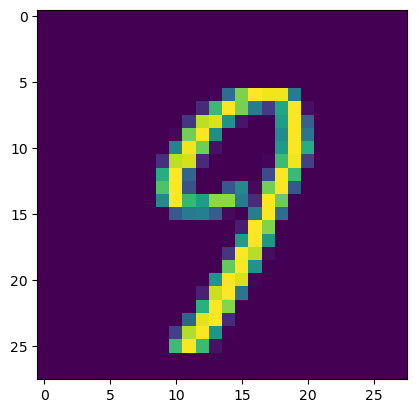

8


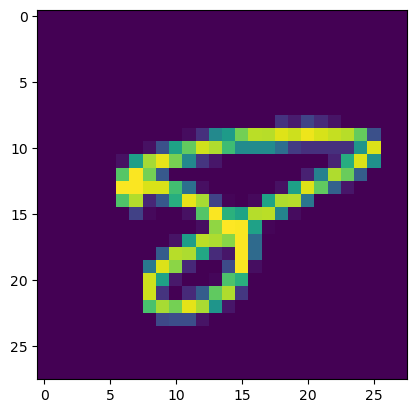

5


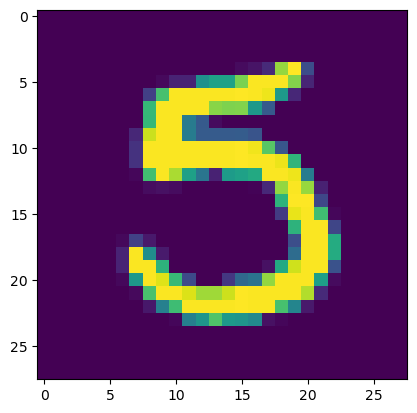

9


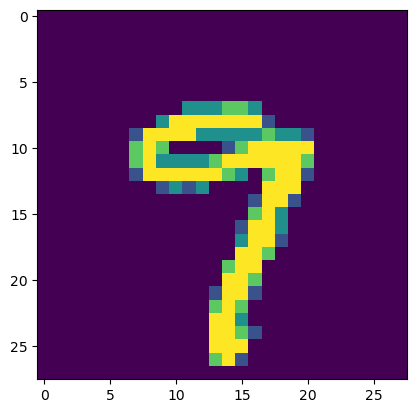

3


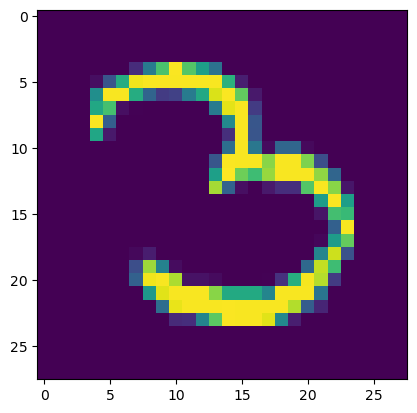

Image shape (before transform): torch.Size([1, 28, 28])
Label (class index): 5
Image shape (after transform): torch.Size([784])
Label: 5
Total training samples: 60000
Total test samples: 10000


In [11]:
# Explore data

# Transform for human viewing - no normalisation or flattening
view_transform = transforms.ToTensor()

# New dataset and dataloader for viewing
view_dataset = MNIST(root='./data', train=True, download=True, transform=view_transform)
view_loader = DataLoader(dataset=view_dataset, batch_size=64, shuffle=True)

# Show 5 images
show5(view_loader)

# Explore data shape
sample_image, sample_label = view_dataset[0]

print(f"Image shape (before transform): {sample_image.shape}") # should be (1, 28, 28)
print(f"Label (class index): {sample_label}")  # should be somehting like: 7


print(f"Image shape (after transform): {sample_image.view(-1).shape}")
print(f"Label: {sample_label}")

print(f"Total training samples: {len(train_dataset)}")
print(f"Total test samples: {len(test_dataset)}")



## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [ ]:
## YOUR CODE HERE ##

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [ ]:
## YOUR CODE HERE ##

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [ ]:
## YOUR CODE HERE ##

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
## YOUR CODE HERE ##

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##